In [127]:

# Import Libraries
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Attention, Bidirectional, Dense, Dropout, Embedding, LayerNormalization, Conv1D, GlobalAveragePooling1D, Input, LSTM, MaxPooling1D, GlobalMaxPooling1D, concatenate, BatchNormalization
from tensorflow.keras.models import Model
from sklearn.metrics import f1_score
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from gensim.models import KeyedVectors
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [128]:
df = pd.read_csv("../Datasets/Sarcasm_Headlines_Dataset_v2.csv")
df['is_sarcastic'].value_counts()

is_sarcastic
0    14985
1    13634
Name: count, dtype: int64

In [129]:
# Change to lowercase for all
df['cleaned_headline'] = df['headline'].apply(lambda x: x.lower())  

# Change words to integer, keep max of 20000 most frequent words
tokenizer = Tokenizer(num_words=20000)  
tokenizer.fit_on_texts(df['cleaned_headline'])
sequences = tokenizer.texts_to_sequences(df['cleaned_headline'])

# Pad with 0 if headlines less than 40 words for uniform length
MAX_HEADLINE_LENGTH = 30 
X = pad_sequences(sequences, maxlen = MAX_HEADLINE_LENGTH)

# 1 = sarcastic, 0 = non-sarcastic
y = df['is_sarcastic'].values

# Split to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)


In [130]:
# Model: CNN + BiLSTM + Attention (Parallel)
# Modifications: Word Embedding changed to pretrained Word2Vec

VOCAB_SIZE = 20000
MAX_HEADLINE_LENGTH = 30
EMBED_DIM = 300

# Load pretrained Word2Vec: download the google news file separately (cant be uploaded onto github)
path = "word_embeddings/GoogleNews-vectors-negative300.bin.gz"
word2vec_model = KeyedVectors.load_word2vec_format(path, binary=True)

# Embedding matrix
embedding_matrix = np.zeros((VOCAB_SIZE, EMBED_DIM))
for word, i in tokenizer.word_index.items():
    if i < VOCAB_SIZE and word in word2vec_model:
        embedding_matrix[i] = word2vec_model[word]

# Model embedding
text_input = Input(shape=(MAX_HEADLINE_LENGTH,), dtype=tf.int32, name="text_input")
embedded_words = Embedding(input_dim=VOCAB_SIZE,
                            output_dim=EMBED_DIM,
                            input_length=MAX_HEADLINE_LENGTH,
                            weights=[embedding_matrix],
                            trainable=False)(text_input)

# CNN + Pooling
cnn_input = embedded_words
cnn_layer = Conv1D(filters = 96, kernel_size = 3, activation='relu', kernel_regularizer=regularizers.l2(0.002))(cnn_input)
cnn_layer = MaxPooling1D(pool_size = 2)(cnn_layer)
cnn_layer = Conv1D(filters = 96, kernel_size = 3, activation='relu', kernel_regularizer=regularizers.l2(0.002))(cnn_layer)
cnn_layer = MaxPooling1D(pool_size = 2)(cnn_layer)
cnn_layer = GlobalMaxPooling1D()(cnn_layer)

# BiLSTM + Attention + Pooling
lstm_input = embedded_words
bilstm_layer = Bidirectional(LSTM(192, return_sequences = True, dropout = 0.2, recurrent_dropout = 0.1))(lstm_input)
bilstm_layer = LayerNormalization()(bilstm_layer)
attention_input = bilstm_layer
attention_layer = Attention()([attention_input, attention_input])
attention_layer = LayerNormalization()(attention_layer)
pooling_input =  attention_layer
pooling_layer= GlobalAveragePooling1D()(pooling_input)

# Run in parallel
parallel = concatenate([cnn_layer, pooling_layer])

# Final MLP
dense_layer = Dense(192, activation='relu', kernel_regularizer=regularizers.l2(0.002))(parallel)
dropout_layer = Dropout(0.29)(dense_layer)
output = Dense(1, activation='sigmoid')(dropout_layer)

# Compile model
CNN_LSTM_model = Model(inputs=text_input, outputs=output)
CNN_LSTM_model.compile(optimizer=Adam(learning_rate = 0.00005), loss='binary_crossentropy', metrics=['accuracy'])

CNN_LSTM_model.summary()


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_20        │ (None, 30, 300)   │  6,000,000 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_31 (Conv1D)  │ (None, 28, 96)    │     86,496 │ embedding_20[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_17    │ (None, 30, 384)   │    757,248 │ embedding_20[0][… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_29    │ (None, 14, 96)    │          0 │ conv1d_31[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 384)   │        768 │ bidirectional_17… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_32 (Conv1D)  │ (None, 12, 96)    │     27,744 │ max_pooling1d_29… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_13        │ (None, 30, 384)   │          0 │ layer_normalizat… │
│ (Attention)         │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_30    │ (None, 6, 96)     │          0 │ conv1d_32[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 384)   │        768 │ attention_13[0][… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 96)        │          0 │ max_pooling1d_30… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 384)       │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_16      │ (None, 480)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_33 (Dense)    │ (None, 192)       │     92,352 │ concatenate_16[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 192)       │          0 │ dense_33[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_34 (Dense)    │ (None, 1)         │        193 │ dropout_15[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,965,569 (26.57 MB)

 Trainable params: 965,569 (3.68 MB)

 Non-trainable params: 6,000,000 (22.89 MB)

In [131]:
# this was ran two times at epochs = 20, the output is the second time results
# code changed to epochs = 40 for one time running
# total of 
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,    
    restore_best_weights=True
)

# Train
training = CNN_LSTM_model.fit(
    X_train,            
    y_train,
    batch_size=32,     
    epochs=40,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate
test_loss, test_accuracy = CNN_LSTM_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}%")
print(f"Test Loss: {test_loss:.4f}%")

# Predict
predictions = CNN_LSTM_model.predict(X_test)
y_pred_probs = CNN_LSTM_model.predict(X_test)
y_pred = (predictions > 0.5).astype("int32")

# F1-score
macro_f1 = f1_score(y_test, y_pred, average='macro')
print("Macro F1 Score:", macro_f1)



Epoch 1/40
573/573 ━━━━━━━━━━━━━━━━━━━━ 81s 128ms/step - accuracy: 0.6333 - loss: 1.6062 - val_accuracy: 0.7762 - val_loss: 1.2355
Epoch 2/40
573/573 ━━━━━━━━━━━━━━━━━━━━ 73s 127ms/step - accuracy: 0.7653 - loss: 1.2053 - val_accuracy: 0.8056 - val_loss: 0.9978
Epoch 3/40
573/573 ━━━━━━━━━━━━━━━━━━━━ 72s 126ms/step - accuracy: 0.7964 - loss: 0.9791 - val_accuracy: 0.8113 - val_loss: 0.8502
Epoch 4/40
573/573 ━━━━━━━━━━━━━━━━━━━━ 75s 130ms/step - accuracy: 0.8036 - loss: 0.8446 - val_accuracy: 0.8128 - val_loss: 0.7552
Epoch 5/40
573/573 ━━━━━━━━━━━━━━━━━━━━ 73s 127ms/step - accuracy: 0.8151 - loss: 0.7446 - val_accuracy: 0.8187 - val_loss: 0.6896
Epoch 6/40
573/573 ━━━━━━━━━━━━━━━━━━━━ 74s 129ms/step - accuracy: 0.8233 - loss: 0.6735 - val_accuracy: 0.8259 - val_loss: 0.6409
Epoch 7/40
573/573 ━━━━━━━━━━━━━━━━━━━━ 74s 128ms/step - accuracy: 0.8312 - loss: 0.6308 - val_accuracy: 0.8262 - val_loss: 0.6140
Epoch 8/40
573/573 ━━━━━━━━━━━━━━━━━━━━ 72s 125ms/step - accuracy: 0.8353 - loss: 0

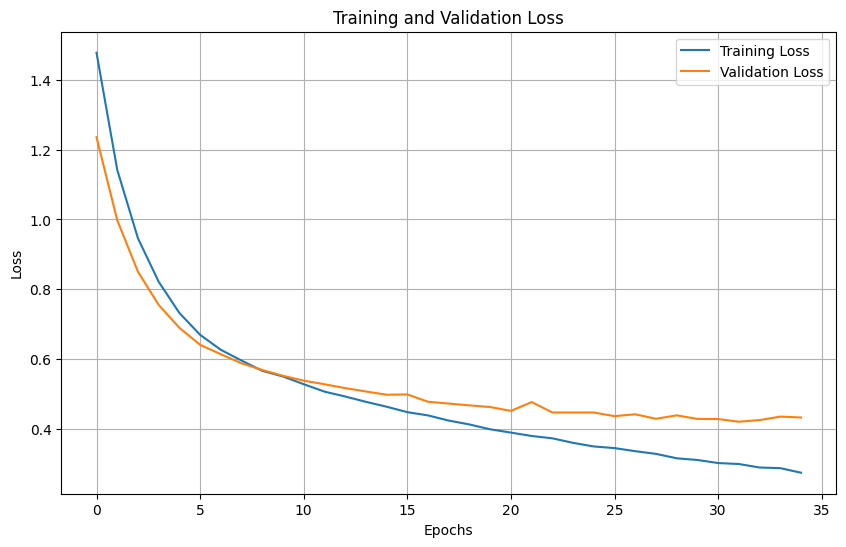

In [132]:
# Plot the training loss + validation loss on same graph
train_loss = training.history['loss']
val_loss = training.history['val_loss']

# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

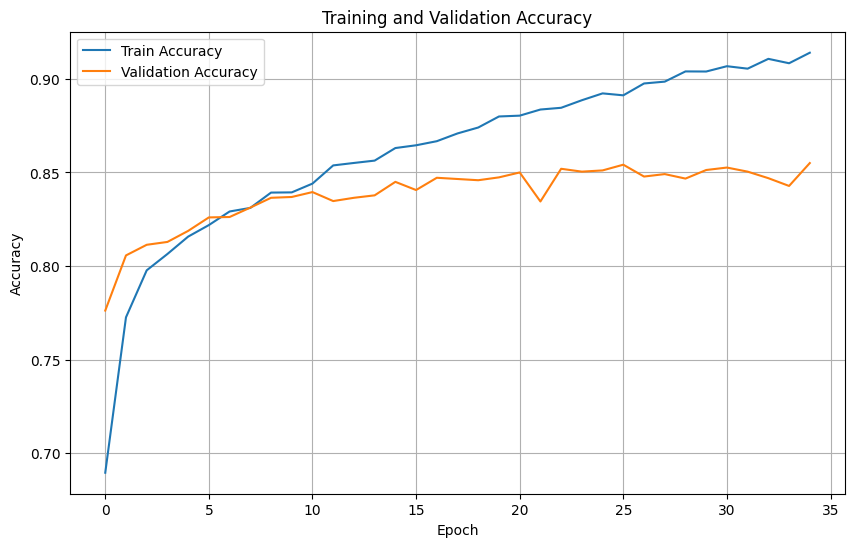

In [133]:
# Plot the training accuracy + validation accuracy on same graph
train_accuracy = training.history['accuracy']
test_accuracy = training.history['val_accuracy']

plt.figure(figsize=(10, 6))
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(test_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()